### [Figuras_finales.ipynb](file:///c:/Users/ECD1PM/Repositories/TFM/TFM-DanielEcheverri-Publico/Anexo_2_codigo_figuras_propias/Figuras_finales.ipynb)

Agregar celdas para cargar datos, calcular métricas y graficar resultados similares a `Figuras_propias_codigo.ipynb`.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'percentiles_comparacion.csv'
data = pd.read_csv(file_path)

# Mostrar las primeras filas para inspeccionar la estructura del archivo
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   deployment                     88 non-null     object 
 1   percentil_95_en_datos_CPU      88 non-null     float64
 2   percentil_95_predecido_CPU     88 non-null     float64
 3   porcentaje_diferencia_CPU      88 non-null     float64
 4   percentil_95_en_datos_Memory   88 non-null     float64
 5   percentil_95_predecido_Memory  88 non-null     float64
 6   porcentaje_diferencia_Memory   88 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.9+ KB


In [3]:
# Calcular CPU_95_MARGEN y MEMORY_95_MARGEN
data['CPU_95_MARGEN'] = (data['percentil_95_en_datos_CPU'] * 1.15).round(4)
data['MEMORY_95_MARGEN'] = (data['percentil_95_en_datos_Memory'] * 1.15).round(2)

# Verificar las nuevas columnas
data[['percentil_95_en_datos_CPU', 'CPU_95_MARGEN', 'percentil_95_en_datos_Memory', 'MEMORY_95_MARGEN']].head()

,percentil_95_en_datos_CPU,CPU_95_MARGEN,percentil_95_en_datos_Memory,MEMORY_95_MARGEN
0,0.0058,0.0067,450.97,518.62
1,0.0107,0.0123,4972.45,5718.32
2,0.0056,0.0064,277.03,318.58
3,0.0631,0.0726,242.43,278.79
4,0.0252,0.0290,650.34,747.89


In [24]:
# CPU_REQUEST_CORRECTO
data['CPU_REQUEST_CORRECTO'] = np.where(
    data['percentil_95_predecido_CPU'].between(data['percentil_95_en_datos_CPU'] * 0.95, data['CPU_95_MARGEN'], inclusive='both') & 
    data['percentil_95_predecido_CPU'].notnull() & 
    data['percentil_95_en_datos_CPU'].notnull() & 
    data['CPU_95_MARGEN'].notnull(),
    True,
    False
)
    
# MEMORY_REQUEST_CORRECTO
data['MEMORY_REQUEST_CORRECTO'] = np.where(
    data['percentil_95_predecido_Memory'].between(data['percentil_95_en_datos_Memory'] * 0.95, data['MEMORY_95_MARGEN'], inclusive='both') & 
    data['percentil_95_predecido_Memory'].notnull() & 
    data['percentil_95_en_datos_Memory'].notnull() & 
    data['MEMORY_95_MARGEN'].notnull(),
    True,
    False
)

In [25]:
# CPU_SUBASIGNADO
data['CPU_SUBASIGNADO'] = np.where(
    data['percentil_95_predecido_CPU'] < (data['percentil_95_en_datos_CPU'] * 0.95),
    True,
    False
)
data['CPU_SUBASIGNADO'] = data['CPU_SUBASIGNADO'] & data['percentil_95_predecido_CPU'].notnull() & data['percentil_95_en_datos_CPU'].notnull()

# MEMORY_SUBASIGNADO
data['MEMORY_SUBASIGNADO'] = np.where(
    data['percentil_95_predecido_Memory'] < (data['percentil_95_en_datos_Memory'] * 0.95),
    True,
    False
)
data['MEMORY_SUBASIGNADO'] = data['MEMORY_SUBASIGNADO'] & data['percentil_95_predecido_Memory'].notnull() & data['percentil_95_en_datos_Memory'].notnull()

In [26]:
# CPU_SOBREASIGNADO
data['CPU_SOBREASIGNADO'] = np.where(
    data['percentil_95_predecido_CPU'] > data['CPU_95_MARGEN'],
    True,
    False
)
data['CPU_SOBREASIGNADO'] = data['CPU_SOBREASIGNADO'] & data['percentil_95_predecido_CPU'].notnull() & data['CPU_95_MARGEN'].notnull()

# MEMORY_SOBREASIGNADO
data['MEMORY_SOBREASIGNADO'] = np.where(
    data['percentil_95_predecido_Memory'] > data['MEMORY_95_MARGEN'],
    True,
    False
)
data['MEMORY_SOBREASIGNADO'] = data['MEMORY_SOBREASIGNADO'] & data['percentil_95_predecido_Memory'].notnull() & data['MEMORY_95_MARGEN'].notnull()

In [27]:
# SIN_ASIGNAR_CPU
data['SIN_ASIGNAR_CPU'] = data['percentil_95_predecido_CPU'].isnull() | data['percentil_95_en_datos_CPU'].isnull() | data['CPU_95_MARGEN'].isnull()
# SIN_ASIGNAR_MEMORY
data['SIN_ASIGNAR_MEMORY'] = data['percentil_95_predecido_Memory'].isnull() | data['percentil_95_en_datos_Memory'].isnull() | data['MEMORY_95_MARGEN'].isnull()

In [28]:
# Ajustar columnas CPU
data.loc[data['SIN_ASIGNAR_CPU'], ['CPU_REQUEST_CORRECTO', 'CPU_SUBASIGNADO', 'CPU_SOBREASIGNADO']] = False

# Asegurar que solo una de las condiciones sea True
cpu_conditions = ['CPU_REQUEST_CORRECTO', 'CPU_SUBASIGNADO', 'CPU_SOBREASIGNADO']
data[cpu_conditions] = data[cpu_conditions].astype(bool)

# Verificar si más de una condición es True y corregir si es necesario
for index, row in data.iterrows():
    if data.loc[index, 'SIN_ASIGNAR_CPU']:
        continue  # Ya está ajustado
    true_conditions = row[cpu_conditions].sum()
    if true_conditions > 1:
        # Priorizar Correcto > Subasignado > Sobreasignado
        if row['CPU_REQUEST_CORRECTO']:
            data.at[index, 'CPU_SUBASIGNADO'] = False
            data.at[index, 'CPU_SOBREASIGNADO'] = False
        elif row['CPU_SUBASIGNADO']:
            data.at[index, 'CPU_SOBREASIGNADO'] = False

# Ajustar columnas Memory
data.loc[data['SIN_ASIGNAR_MEMORY'], ['MEMORY_REQUEST_CORRECTO', 'MEMORY_SUBASIGNADO', 'MEMORY_SOBREASIGNADO']] = False

# Asegurar que solo una de las condiciones sea True
memory_conditions = ['MEMORY_REQUEST_CORRECTO', 'MEMORY_SUBASIGNADO', 'MEMORY_SOBREASIGNADO']
data[memory_conditions] = data[memory_conditions].astype(bool)

# Verificar si más de una condición es True y corregir si es necesario
for index, row in data.iterrows():
    if data.loc[index, 'SIN_ASIGNAR_MEMORY']:
        continue  # Ya está ajustado
    true_conditions = row[memory_conditions].sum()
    if true_conditions > 1:
        # Priorizar Correcto > Subasignado > Sobreasignado
        if row['MEMORY_REQUEST_CORRECTO']:
            data.at[index, 'MEMORY_SUBASIGNADO'] = False
            data.at[index, 'MEMORY_SOBREASIGNADO'] = False
        elif row['MEMORY_SUBASIGNADO']:
            data.at[index, 'MEMORY_SOBREASIGNADO'] = False

In [40]:
# Definir el orden deseado de las columnas
orden_columnas = [
    'deployment',
    
    # Columnas relacionadas con CPU
    'percentil_95_predecido_CPU',
    'percentil_95_en_datos_CPU',
    'CPU_95_MARGEN',
    'CPU_REQUEST_CORRECTO',
    'CPU_SUBASIGNADO',
    'CPU_SOBREASIGNADO',
    'SIN_ASIGNAR_CPU',
    
    # Columnas relacionadas con Memoria
    'percentil_95_predecido_Memory',
    'percentil_95_en_datos_Memory',
    'MEMORY_95_MARGEN',
    'MEMORY_REQUEST_CORRECTO',
    'MEMORY_SUBASIGNADO',
    'MEMORY_SOBREASIGNADO',
    'SIN_ASIGNAR_MEMORY'
]

# Definir las columnas relevantes para CPU y Memoria
columnas_cpu = [
    'CPU_REQUEST_CORRECTO',
    'CPU_SUBASIGNADO',
    'CPU_SOBREASIGNADO',
    'SIN_ASIGNAR_CPU'
]

columnas_memory = [
    'MEMORY_REQUEST_CORRECTO',
    'MEMORY_SUBASIGNADO',
    'MEMORY_SOBREASIGNADO',
    'SIN_ASIGNAR_MEMORY'
]

# Reordenar las columnas del DataFrame según el orden definido
data = data[orden_columnas]

In [30]:
from IPython.display import display, HTML

# Contar los valores True en cada columna
frecuencia_cpu = data[columnas_cpu].sum()
frecuencia_memory = data[columnas_memory].sum()

# Convertir a DataFrame para facilitar la visualización
frecuencia_cpu = frecuencia_cpu.reset_index()
frecuencia_cpu.columns = ['Categoría', 'Frecuencia']
frecuencia_memory = frecuencia_memory.reset_index()
frecuencia_memory.columns = ['Categoría', 'Frecuencia']

# Mostrar las tablas sin índices usando estilos
print("Frecuencia de asignación de CPU request inicial:")
display(HTML(frecuencia_cpu.to_html(index=False)))

print("\nFrecuencia de asignación de Memory request inicial:")
display(HTML(frecuencia_memory.to_html(index=False)))

Frecuencia de asignación de CPU request inicial:


Categoría,Frecuencia
CPU_REQUEST_CORRECTO,68
CPU_SUBASIGNADO,0
CPU_SOBREASIGNADO,20
SIN_ASIGNAR_CPU,0



Frecuencia de asignación de Memory request inicial:


Categoría,Frecuencia
MEMORY_REQUEST_CORRECTO,86
MEMORY_SUBASIGNADO,2
MEMORY_SOBREASIGNADO,0
SIN_ASIGNAR_MEMORY,0


In [12]:
AZUL = "#0072B2"        # Azul fuerte
NARANJA = "#D55E00"     # Naranja fuerte
VERDE = "#009E73"       # Verde fuerte
ROSA = "#CC79A7"        # Rosa magenta fuerte

In [39]:
# Crear la columna 'anonimo' con valores 'deploy1', 'deploy2', ..., 'deployN'
data['anonimo'] = ['deploy' + str(i+1) for i in range(len(data))]

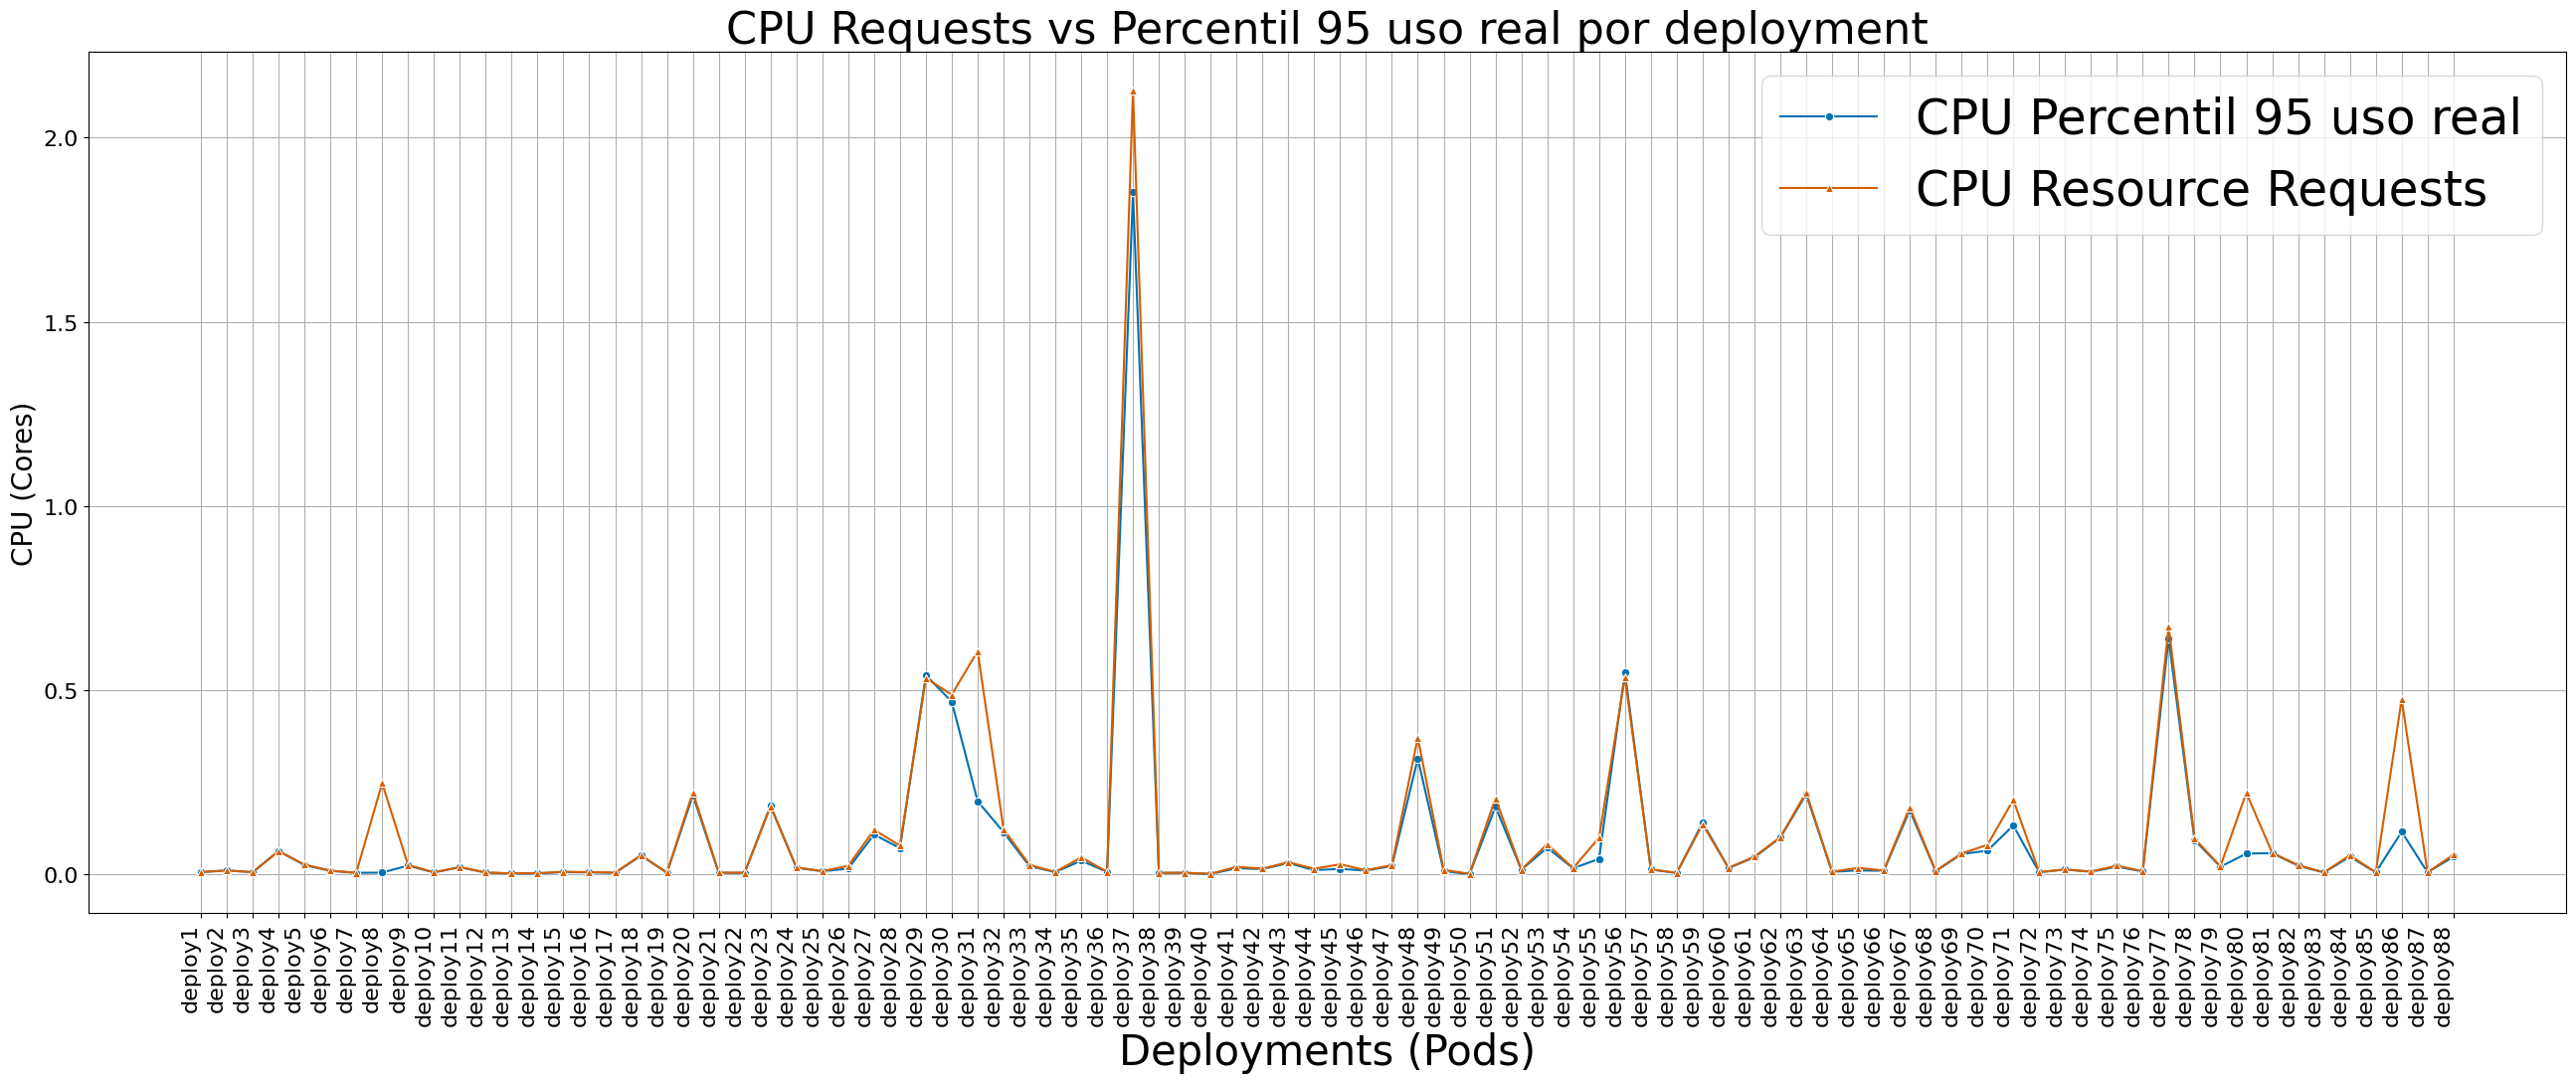

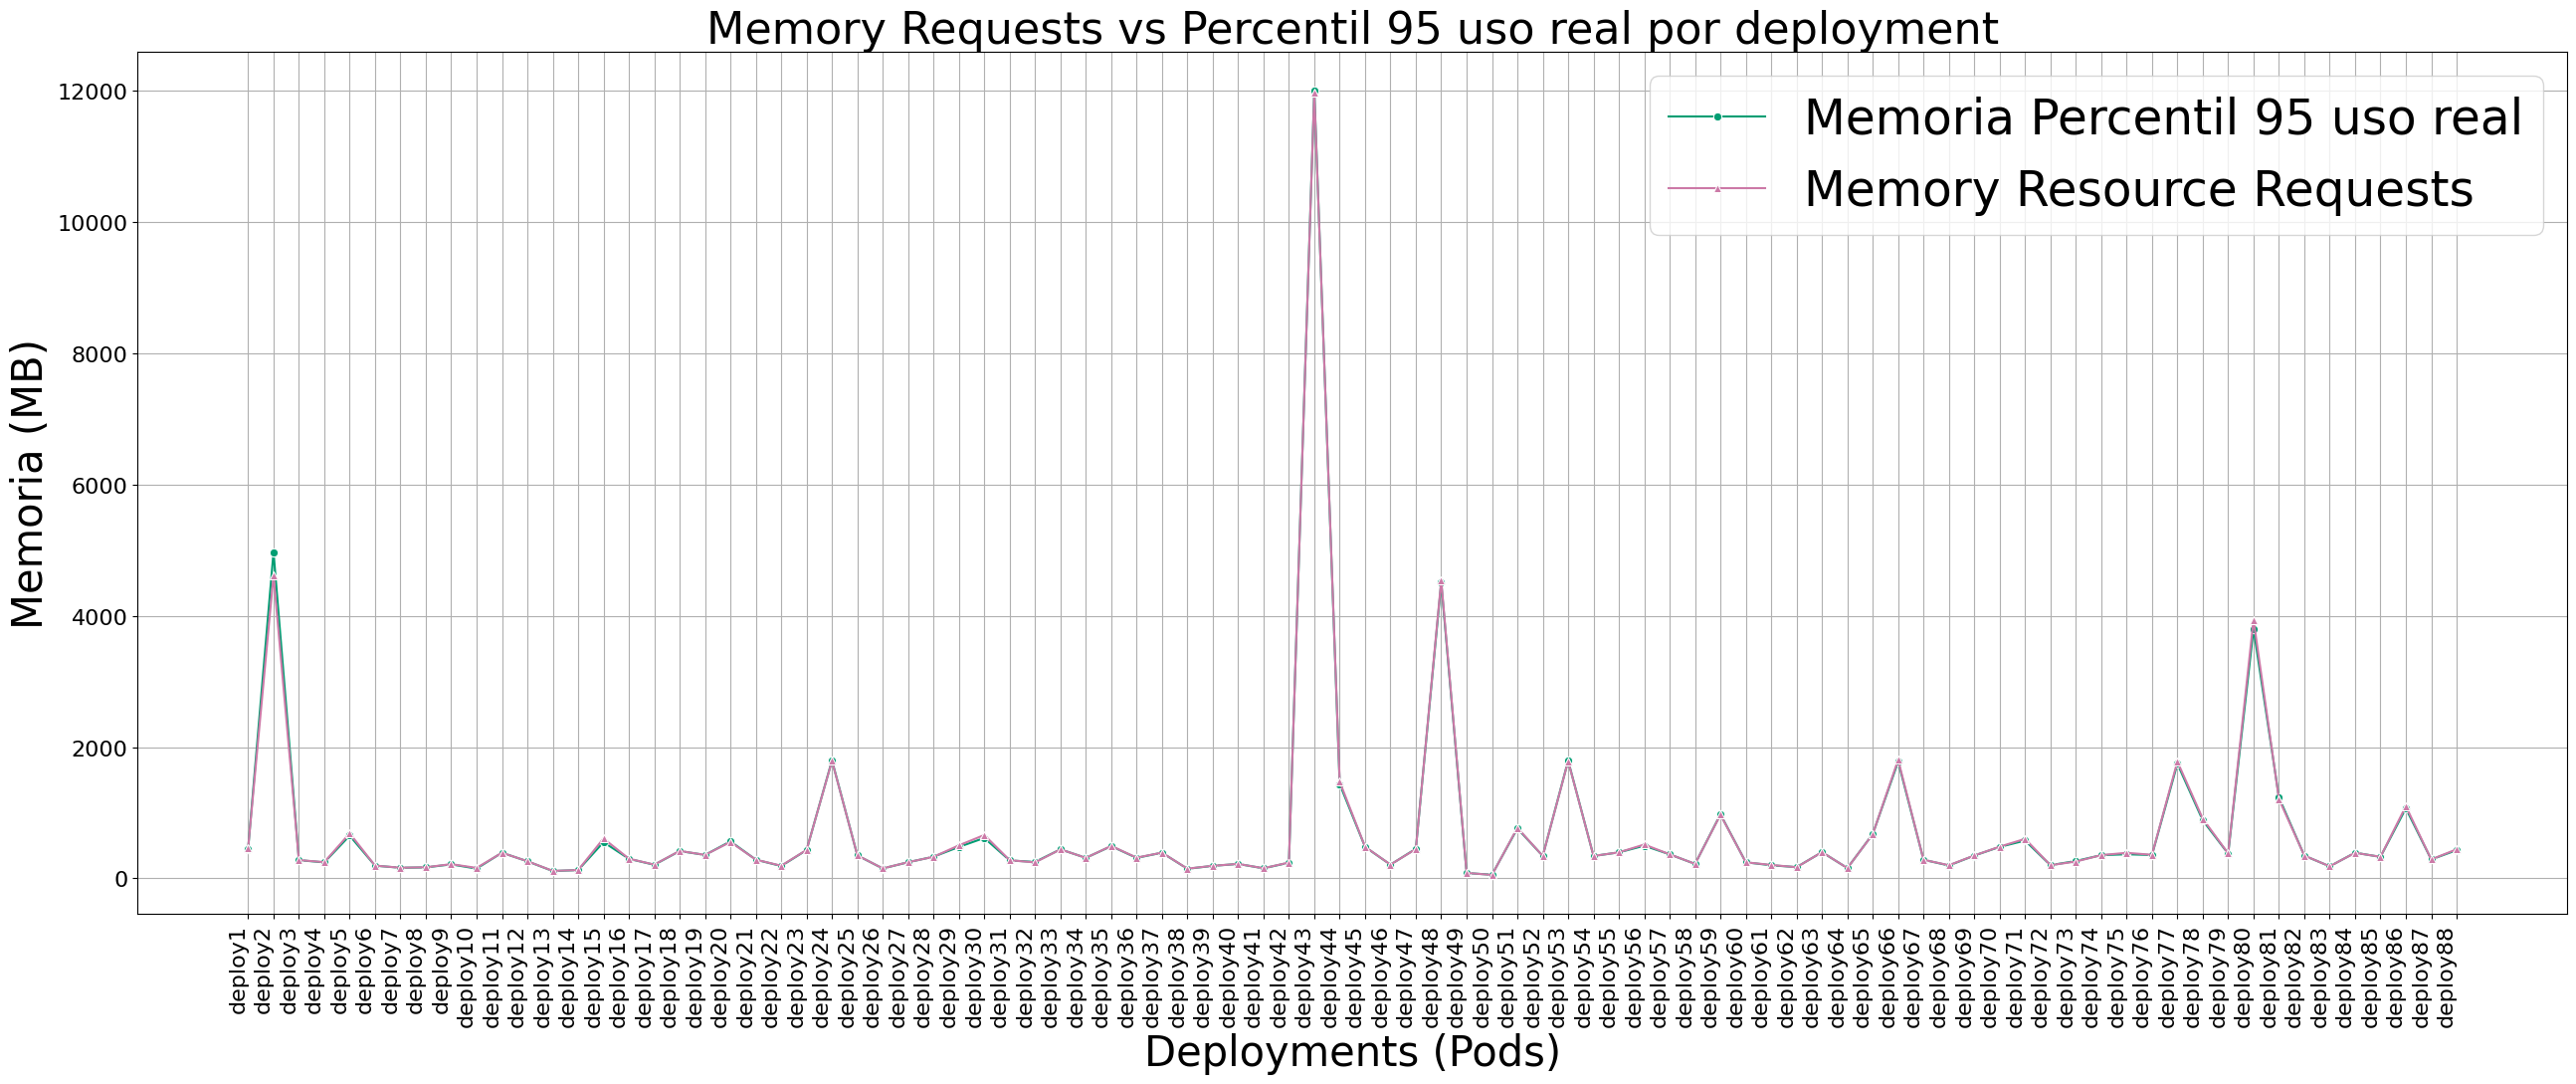

In [38]:
# Gráfico de CPU
plt.figure(figsize=(26,11))
sns.lineplot(x='anonimo', y='percentil_95_en_datos_CPU', data=data, marker='o', label='CPU Percentil 95 uso real', color=AZUL)
sns.lineplot(x='anonimo', y='percentil_95_predecido_CPU', data=data, marker='^', label='CPU Resource Requests', color=NARANJA)
plt.ylabel('CPU (Cores)', fontsize=20)
plt.title('CPU Requests vs Percentil 95 uso real por deployment', fontsize=32)
plt.xticks(rotation=90, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Deployments (Pods)', fontsize=30)
plt.legend(fontsize=35)
plt.tight_layout()
plt.grid(True)
plt.show()

# Gráfico de Memoria
plt.figure(figsize=(26, 11))
sns.lineplot(x='anonimo', y='percentil_95_en_datos_Memory', data=data, marker='o', label='Memoria Percentil 95 uso real', color=VERDE)
sns.lineplot(x='anonimo', y='percentil_95_predecido_Memory', data=data, marker='^', label='Memory Resource Requests', color=ROSA)
plt.ylabel('Memoria (MB)', fontsize=30)
plt.title('Memory Requests vs Percentil 95 uso real por deployment', fontsize=32)
plt.xticks(rotation=90, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Deployments (Pods)', fontsize=30)
plt.legend(fontsize=35)
plt.tight_layout()
plt.grid(True)
plt.show()

In [32]:
# Calcular la diferencia para CPU
cpu_sobreasignado_diff = data.loc[data['CPU_SOBREASIGNADO'], 'percentil_95_predecido_CPU'] - data.loc[data['CPU_SOBREASIGNADO'], 'percentil_95_en_datos_CPU']
cpu_subasignado_diff = data.loc[data['CPU_SUBASIGNADO'], 'percentil_95_predecido_CPU'] - data.loc[data['CPU_SUBASIGNADO'], 'percentil_95_en_datos_CPU']

# Calcular la diferencia para Memoria
memory_sobreasignado_diff = data.loc[data['MEMORY_SOBREASIGNADO'], 'percentil_95_predecido_Memory'] - data.loc[data['MEMORY_SOBREASIGNADO'], 'percentil_95_en_datos_Memory']
memory_subasignado_diff = data.loc[data['MEMORY_SUBASIGNADO'], 'percentil_95_predecido_Memory'] - data.loc[data['MEMORY_SUBASIGNADO'], 'percentil_95_en_datos_Memory']

print(f"Diferencia de CPU sobreasignado: {cpu_sobreasignado_diff.sum()}")
print(f"Diferencia de CPU subasignado: {cpu_subasignado_diff.sum()}")
print(f"Diferencia de Memoria sobreasignado: {memory_sobreasignado_diff.sum()}")
print(f"Diferencia de Memoria subasignado: {memory_subasignado_diff.sum()}")

Diferencia de CPU sobreasignado: 1.4285999999999999
Diferencia de CPU subasignado: 0.0
Diferencia de Memoria sobreasignado: 0.0
Diferencia de Memoria subasignado: -356.51999999999947
